# Walking-Forward VAR Model with all Variables - Weekly Data

In [137]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

**1. Importing the data**

In [30]:
dwfw1 = pd.read_csv("../Data/weekly_data_copy.csv")
dwfw1 = dwfw1.dropna()

In [31]:
# convert DateTime column into datetime format
dwfw1["datetime"] = pd.to_datetime(dwfw1['datetime'])
# set DateTime as index
dwfw1.set_index("datetime", inplace=True)
dwfw1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 2012-01-08 00:00:00+00:00 to 2019-12-01 00:00:00+00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   413 non-null    float64
 1   suction_tension (40cm)   413 non-null    float64
 2   suction_tension (70cm)   413 non-null    float64
 3   water_temperature        413 non-null    float64
 4   barometric_pressure_qfe  413 non-null    float64
 5   dew_point                413 non-null    float64
 6   water_level              413 non-null    float64
 7   inflow_linth (m3/s)      413 non-null    float64
 8   outflow_limmat (m3/s)    413 non-null    float64
 9   precipitation (mm)       413 non-null    float64
 10  Evapotranspiration (mm)  413 non-null    float64
 11  change_rate              413 non-null    float64
dtypes: float64(12)
memory usage: 41.9 KB


**2. Visualizing the Time Series**

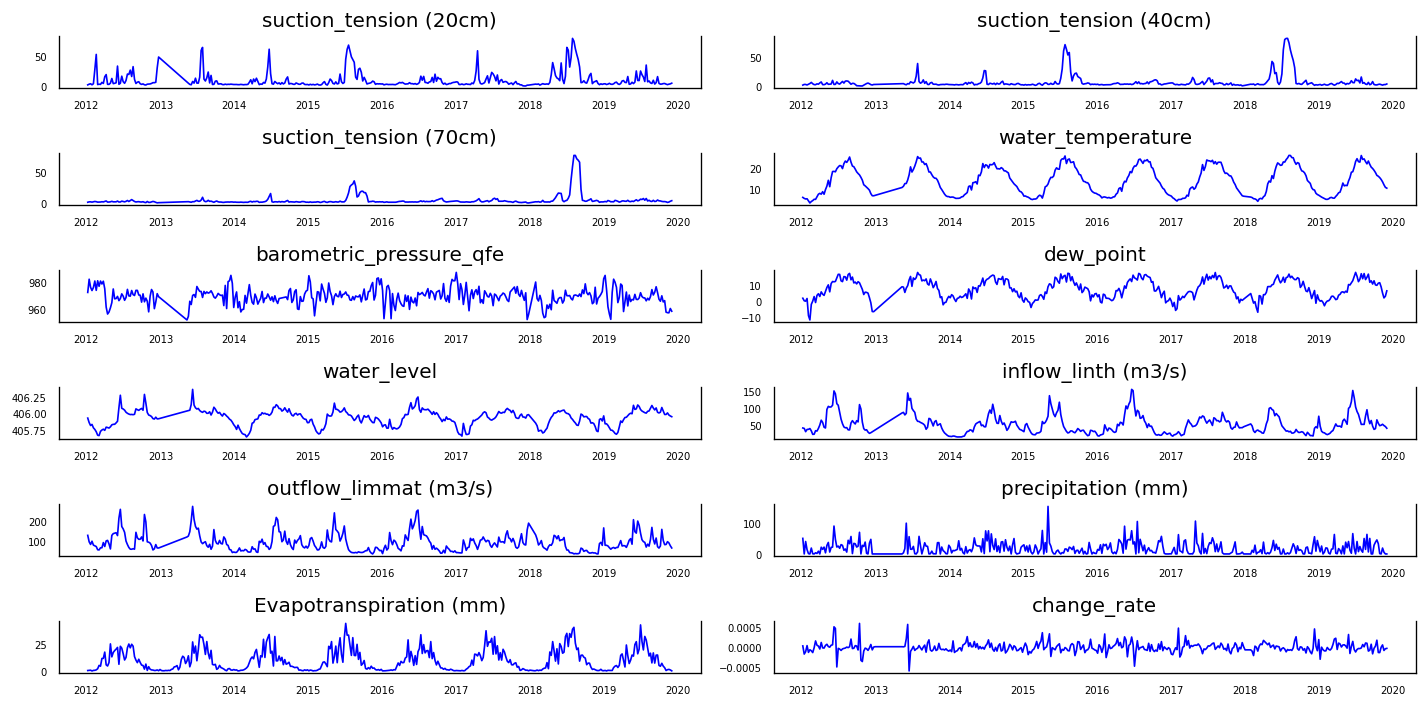

In [32]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = dwfw1[dwfw1.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dwfw1.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [33]:
# drop variable change rate
dwfw1.drop(columns="change_rate", inplace=True)

**3. Checking for stationarity**

In [34]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [35]:
for name, column in dwfw1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8177
 No. Lags Chosen       = 4
 Critical value 1%     = -3.446
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4604
 No. Lags Chosen       = 6
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has 

Here we can see that according to the Augmented Dickey-Fullery Test, all variables are stationary. However we are going to check the auto- and partial autocorrelation to check graphically.

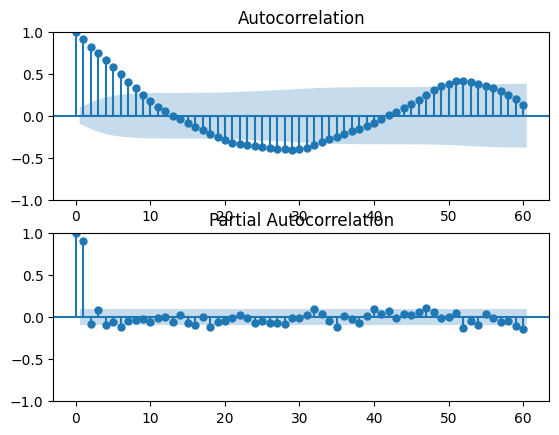

In [40]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dwfw1["water_level"], lags=60, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dwfw1["water_level"], lags=60, ax=ax[1])
plt.show()

**4. Splitting the data into train and test set.**

In [79]:
def ts_train_test_split(dwfw1, test_size):
    len_test = int(dwfw1.shape[0]*test_size)
    split_point = dwfw1.index[-len_test]
    dwfw1_train = dwfw1[dwfw1.index < split_point]
    dwfw1_test = dwfw1[dwfw1.index >= split_point]
    
    return dwfw1_train, dwfw1_test


In [132]:
dwfw1_train, dwfw1_test = ts_train_test_split(dwfw1, 0.243)
dwfw1_test

,suction_tension (20cm),suction_tension (40cm),suction_tension (70cm),water_temperature,barometric_pressure_qfe,dew_point,water_level,inflow_linth (m3/s),outflow_limmat (m3/s),precipitation (mm),Evapotranspiration (mm)
datetime,,,,,,,,,,,
2018-01-07 00:00:00+00:00,2.124579,1.578283,1.264310,6.126263,965.726207,2.418575,405.926919,49.322818,168.073933,0.0,0.74
2018-01-14 00:00:00+00:00,2.471515,2.078182,1.648485,6.042121,970.415657,3.123131,405.900758,50.988055,156.331642,0.0,0.50
2018-01-21 00:00:00+00:00,2.818451,2.578081,2.032660,5.957980,975.105107,3.827688,405.874596,52.653291,144.589352,0.0,0.37
2018-01-28 00:00:00+00:00,3.165387,3.077980,2.416835,5.873838,979.794557,4.532245,405.848434,54.318527,132.847062,0.0,0.43
2018-02-04 00:00:00+00:00,2.828734,2.828734,2.252219,5.628382,967.839177,1.422042,405.808672,48.354299,112.183109,11.9,1.01
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-03 00:00:00+00:00,3.102348,2.332702,2.337500,14.413468,958.032222,8.698620,405.981773,50.585136,85.093263,0.0,0.60
2019-11-10 00:00:00+00:00,2.272055,1.451500,1.349797,13.263024,957.653361,4.858711,406.005953,53.342241,99.203155,19.0,1.35
2019-11-17 00:00:00+00:00,3.036545,2.373341,1.945151,11.821541,957.553268,1.792035,405.973563,49.528804,92.942345,5.4,1.63


In [111]:
varmodel2 = VAR(dwfw1_train)
varmodel2.select_order(maxlags=9).summary()

,AIC,BIC,FPE,HQIC
0,34.18,34.32,6.996e+14,34.24
1,22.82,24.43*,8.170e+09,23.47*
2,22.59*,25.67,6.475e+09*,23.82
3,22.69,27.26,7.246e+09,24.52
4,22.97,29.00,9.639e+09,25.38
5,23.26,30.77,1.321e+10,26.26
6,23.39,32.38,1.554e+10,26.98
7,23.59,34.05,1.991e+10,27.77
8,23.44,35.38,1.825e+10,28.21
9,23.55,36.97,2.236e+10,28.92


In [101]:
# creating a walk forward fuction that will split a time series into training and testing set, and return a tuple of the test set 
# and the predicited test set
def walk_forward_VAR(dwfw1, test_size, lag_order):
    # splitting the data into train and test set
    dwfw1_train, dwfw1_test = ts_train_test_split(dwfw1, test_size)
 
    # makes a list of lists from the train set
    history = [list(x) for x in np.array(dwfw1_train)] 
    forecasts = [] # empty list to store our forecasts
    
    for t in range(dwfw1_test.shape[0]): # for each test set,
        # initialize a VAR model on the train set,
        model = VAR(np.array(history)) 
        model_fit = model.fit(lag_order) # fits the model
        
        # forecast just the next time step
        yhat = model_fit.forecast(model.y, steps=1)
        
        # add the forecast to the forecasts list
        forecasts.append(list(yhat[0])) 
        
        # add the actual test value as the last observation of the 
        # train set
        history.append(list(np.array(dwfw1_test)[t])) 
            
    # return a tuple of the test set and the predicited test set as
    # a tuple of dataframes 
    return dwfw1_test, pd.DataFrame(np.array(forecasts), index=dwfw1_test.index, columns=dwfw1.columns)

In [133]:
dwfw1_results_test, dwfw1_results_pred = walk_forward_VAR(dwfw1, 0.243, 2)

<AxesSubplot: xlabel='datetime'>

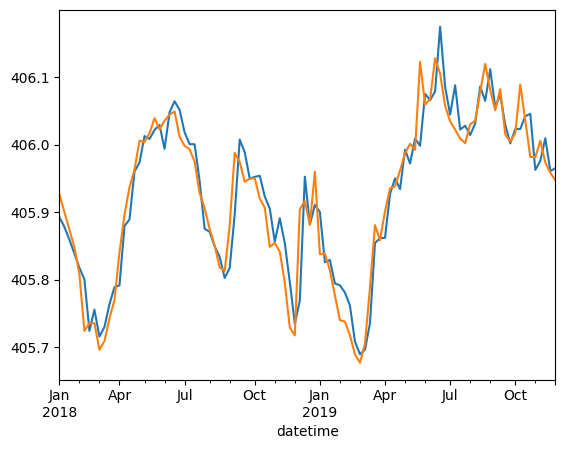

In [134]:
import matplotlib.pyplot as plt
dwfw1_results_pred["water_level"].plot()
dwfw1_results_test["water_level"].plot()

In [135]:
# defining mean absolute percentage error (MAPE) metric
def mape(df_true, df_pred):
    
    error = df_true - df_pred # calculates the error
    
    return 100 * np.mean(np.abs(error/df_true), axis=0) # resturns the MAPE
 
# importing mean square error
from sklearn.metrics import mean_squared_error as mse

# defining a function to return a dataframe of rmse and mape scores
def get_rmse_and_mape(df_true, df_pred):
    results = {'RMSE': mse(np.array(df_true), np.array(df_pred), multioutput='raw_values', squared=False), 
               'MAPE (%)': mape(np.array(df_true), np.array(df_pred))}
    
    return pd.DataFrame(results, index=df_true.columns)

In [136]:
get_rmse_and_mape(dwfw1_results_pred, dwfw1_results_test)

,RMSE,MAPE (%)
suction_tension (20cm),9.647228,103.134812
suction_tension (40cm),6.994615,118.744827
suction_tension (70cm),5.320120,68.499676
water_temperature,0.946794,5.961468
barometric_pressure_qfe,5.269079,0.424746
dew_point,2.226593,183.462980
water_level,0.037318,0.006792
inflow_linth (m3/s),11.486960,15.834076
outflow_limmat (m3/s),25.327612,20.419337
precipitation (mm),17.552894,82.224596


0.243, 2
RMSE	MAPE (%)
suction_tension (20cm)	9.647228	103.134812
suction_tension (40cm)	6.994615	118.744827
suction_tension (70cm)	5.320120	68.499676
water_temperature	0.946794	5.961468
barometric_pressure_qfe	5.269079	0.424746
dew_point	2.226593	183.462980
water_level	0.037318	0.006792
inflow_linth (m3/s)	11.486960	15.834076
outflow_limmat (m3/s)	25.327612	20.419337
precipitation (mm)	17.552894	82.224596
Evapotranspiration (mm)	6.421075	95.584501

0.25, 1	                    
                        
                        RMSE	MAPE (%)
suction_tension (20cm)	9.648856	184.277178
suction_tension (40cm)	6.616738	124.267666
suction_tension (70cm)	5.303746	82.954985
water_temperature	1.031573	6.266376
barometric_pressure_qfe	5.391831	0.421852
dew_point	2.278699	626.272321
water_level	0.040464	0.007438
inflow_linth (m3/s)	11.399036	16.168351
outflow_limmat (m3/s)	27.970192	21.838491
precipitation (mm)	17.425406	84.925731
Evapotranspiration (mm)	6.349942	56.557285

0.25, 2	                                                    
                            RMSE	MAPE (%)
suction_tension (20cm)	9.573975	102.399977
suction_tension (40cm)	6.912356	117.726962
suction_tension (70cm)	5.249546	68.534834
water_temperature	0.954783	6.240276
barometric_pressure_qfe	5.505667	0.435506
dew_point	2.213361	179.746194
water_level	0.039318	0.007163
inflow_linth (m3/s)	11.324771	15.501643
outflow_limmat (m3/s)	27.914729	21.940853
precipitation (mm)	17.334345	82.026939
Evapotranspiration (mm)	6.335654	94.833051

0.25, 3
RMSE	MAPE (%)
suction_tension (20cm)	9.836035	476.246277
suction_tension (40cm)	6.978751	119.774697
suction_tension (70cm)	5.592311	553.519531
water_temperature	0.978655	6.042456
barometric_pressure_qfe	5.741145	0.453069
dew_point	2.254087	66.480280
water_level	0.042081	0.007572
inflow_linth (m3/s)	11.553234	16.762876
outflow_limmat (m3/s)	27.507780	23.068607
precipitation (mm)	17.708342	81.442550
Evapotranspiration (mm)	6.459573	60.913577


0.01, 2
RMSE	MAPE (%)
suction_tension (20cm)	3.793425	42.816136
suction_tension (40cm)	1.020630	46.432952
suction_tension (70cm)	0.774707	35.125856
water_temperature	0.467615	3.865120
barometric_pressure_qfe	5.162898	0.512227
dew_point	2.067950	38.283401
water_level	0.025126	0.005315
inflow_linth (m3/s)	4.610613	8.081559
outflow_limmat (m3/s)	13.470024	14.378982
precipitation (mm)	7.135643	74.573759
Evapotranspiration (mm)	2.086791	59.537108

0.03, 2
RMSE	MAPE (%)
suction_tension (20cm)	5.021614	149.635003
suction_tension (40cm)	2.559283	504.440328
suction_tension (70cm)	1.399579	93.382026
water_temperature	0.375983	2.224576
barometric_pressure_qfe	4.716804	0.412028
dew_point	1.867462	23.248032
water_level	0.031170	0.005599
inflow_linth (m3/s)	8.992953	14.296641
outflow_limmat (m3/s)	27.112244	20.949824
precipitation (mm)	16.788932	97.368446
Evapotranspiration (mm)	3.096875	49.802689

0.125, 2
RMSE	MAPE (%)
suction_tension (20cm)	7.308488	95.825417
suction_tension (40cm)	3.804018	180.337443
suction_tension (70cm)	1.808262	79.389233
water_temperature	0.889834	5.498957
barometric_pressure_qfe	5.537485	0.444838
dew_point	2.038081	179.591238
water_level	0.036397	0.006700
inflow_linth (m3/s)	14.161783	16.513237
outflow_limmat (m3/s)	31.220729	19.830087
precipitation (mm)	18.418728	77.303276
Evapotranspiration (mm)	5.878477	106.105824